In [38]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyclustering.cluster.cure import cure
from pyclustering.cluster import cluster_visualizer
from pyclustering.samples.definitions import SIMPLE_SAMPLES
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample
from pyclustering.utils import timedcall
import warnings
warnings.filterwarnings("ignore")

In [39]:
# Loading the dataset

df=pd.read_csv('ecommerce_data.csv',encoding='iso-8859-1')
df['InvoiceDate'] =  pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

In [40]:
# describing the dataset

df.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

<AxesSubplot:>

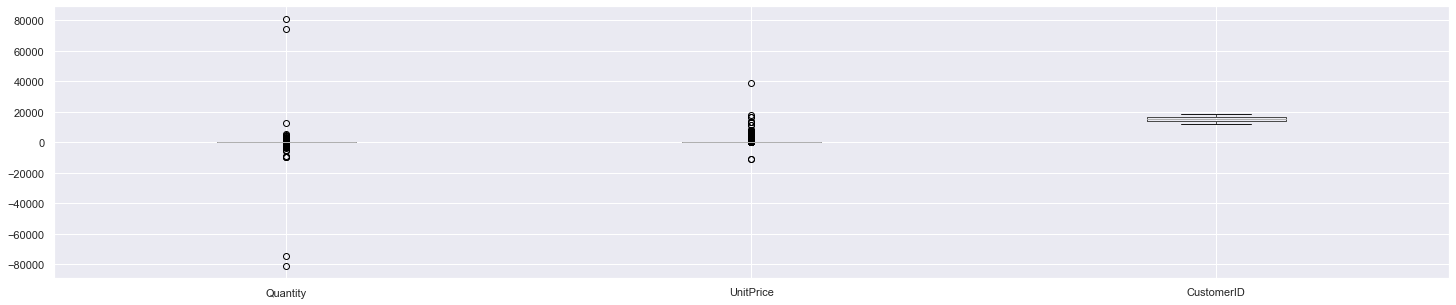

In [41]:
# outliers

plt.figure()
df.boxplot()

In [42]:
# removing the Null Values & filtering Data on the Quantity to be Positive

df=df.dropna().reset_index()
df = df[df.Quantity <=10000]
df = df[df.Quantity >=0]
df=df.sort_values(['Quantity'],ascending=False)
df.shape

(397921, 9)

<AxesSubplot:>

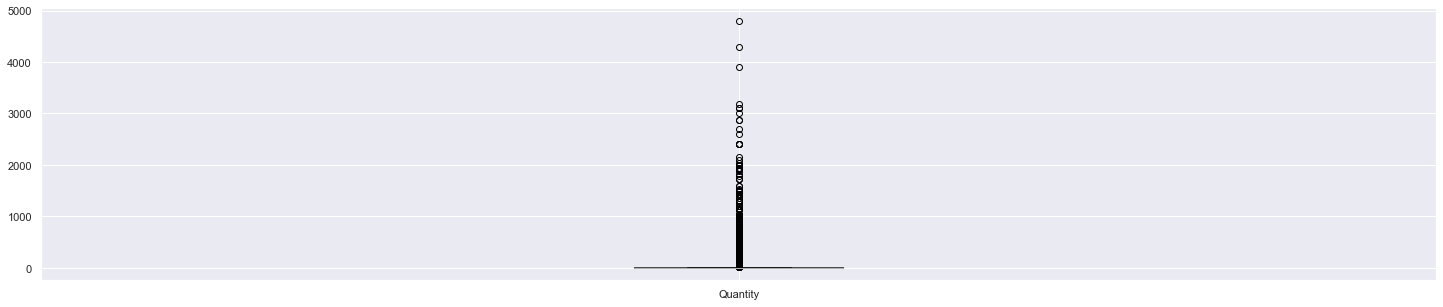

In [60]:

plt.figure()
df.boxplot('Quantity')

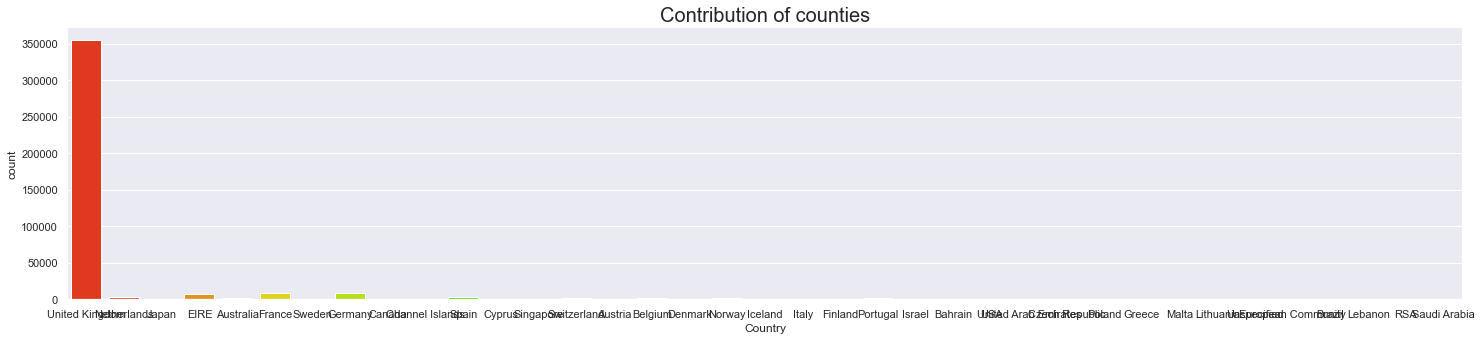

In [44]:
# Countries Contribution at Dataset


plt.rcParams['figure.figsize'] = (25, 5)
sns.countplot(df['Country'], palette = 'hsv')
plt.title('Contribution of counties', fontsize = 20)
plt.show()

In [45]:
# Selecting only UK due to sample size

dfuk=df[df['Country']=='United Kingdom']

In [46]:
# Creating the metrics per Customers due to create the customer Segmentation


# We are going to run the project based on how much times does the customer bought,
# average price of the items that he buys and quantity per buy.


dfukg = (dfuk.groupby(['CustomerID','Country'],as_index=False)
          .agg({'InvoiceNo':'nunique', 'StockCode':'nunique','UnitPrice':'mean','Quantity':'sum'}))
dfukg
dfukg.reset_index()
dfukg['avgitems']=dfukg['Quantity']/dfukg['InvoiceNo']
db=dfukg[['InvoiceNo','UnitPrice','avgitems']]

In [47]:
# Removing the outliers

i=0 
while i<=len(db)-1:
    quartile_1, quartile_3 = np.percentile(db['avgitems'], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr *1.5 )
    upper_bound = quartile_3 + (iqr *1.5)
    
    if db.loc[i,'avgitems']> upper_bound:
        db.loc[i,'outlier']=1
    elif db.loc[i,'avgitems']< lower_bound:
        db.loc[i,'outlier']=1
    else:
        db.loc[i,'outlier']=0
    i=i+1
    
db

InvoiceNo  UnitPrice    avgitems  outlier
0            11   4.367864  115.909091      0.0
1           210   2.655701  122.609524      0.0
2             5   4.999950  294.200000      0.0
3             4   1.904746  180.500000      0.0
4             1   2.498333   70.000000      0.0
...         ...        ...         ...      ...
3914          1   4.765000   45.000000      0.0
3915          1   5.622857   54.000000      0.0
3916          2   5.199167   51.500000      0.0
3917         16   1.614987   87.312500      0.0
3918          3   1.493571  528.666667      1.0

[3919 rows x 4 columns]

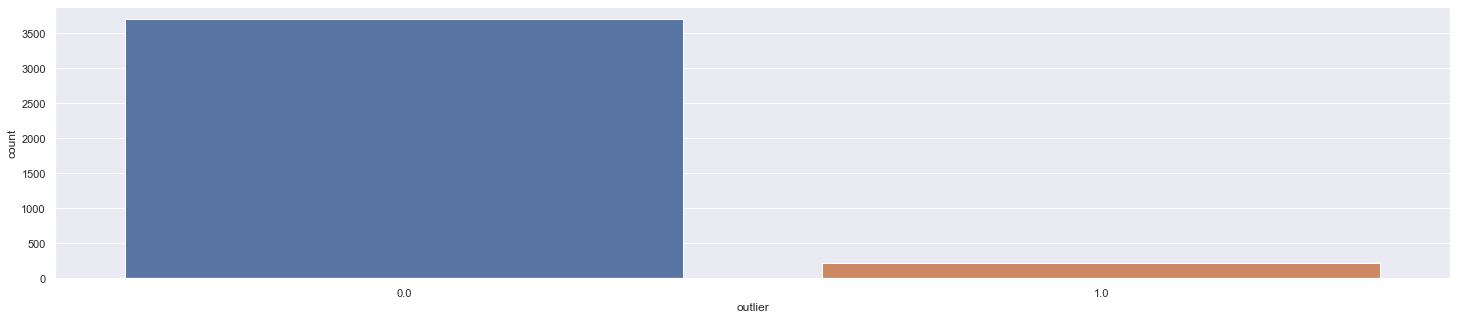

In [48]:
ax = sns.countplot(x="outlier", data=db)

In [49]:
db=db[db['outlier']==0]
db= db.drop(columns=['outlier'])
db

InvoiceNo  UnitPrice    avgitems
0            11   4.367864  115.909091
1           210   2.655701  122.609524
2             5   4.999950  294.200000
3             4   1.904746  180.500000
4             1   2.498333   70.000000
...         ...        ...         ...
3913          1   3.283333   66.000000
3914          1   4.765000   45.000000
3915          1   5.622857   54.000000
3916          2   5.199167   51.500000
3917         16   1.614987   87.312500

[3698 rows x 3 columns]

In [58]:
#Scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled=scaler.fit(db)
x_scaled = scaler.fit_transform(db)
x_scaled

array([[ 9.85610419e-01, -2.03503047e-03, -5.05487418e-01],
       [ 2.96065827e+01, -4.91715951e-02, -4.44316536e-01],
       [ 1.22666532e-01,  1.53665481e-02,  1.12220025e+00],
       ...,
       [-4.52629392e-01,  3.25154449e-02, -1.07067980e+00],
       [-3.08805411e-01,  2.08510718e-02, -1.09350328e+00],
       [ 1.70473033e+00, -7.78228751e-02, -7.66556918e-01]])

clusters: [[4.458715596330276, 2.668083632930538, 407.2612951856734], [4.278824069820854, 2.9369764298660623, 195.13761449333572], [0.9320646613464293, 1.1214209387768435, 15.419247600388138], [1.75, 411.4925, 10.833333333333334], [1.0, 2033.1, 1.0]]
Sample:  pandas.txt 		Execution time:  2.2251981000008527 

[327, 2177, 4887, 4, 1]


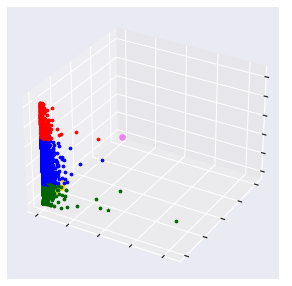

In [62]:
#CURE Algorithm


def template_clustering(number_clusters, path, number_represent_points=1, compression=0.5, draw=True, ccore_flag=True):
    sample = read_sample(path)
    
    cure_instance = cure(sample, number_clusters, number_represent_points, compression, ccore_flag)
    (ticks, _) = timedcall(cure_instance.process)
    
    clusters = cure_instance.get_clusters()
    representors = cure_instance.get_representors()
    means = cure_instance.get_means()
    print('clusters:',means)
    print("Sample: ", path, "\t\tExecution time: ", ticks, "\n")
    print([len(cluster) for cluster in clusters])

    if draw is True:
        visualizer = cluster_visualizer()

        visualizer.append_clusters(clusters, sample)

        for cluster_index in range(len(clusters)):
            visualizer.append_cluster_attribute(0, cluster_index, representors[cluster_index], '*', 10)
            visualizer.append_cluster_attribute(0, cluster_index, [ means[cluster_index] ], 'o')

        visualizer.show()

                


path= 'pandas.txt'
template_clustering(5,path)
